In [1]:
from dfLoader import *
from dataAug import *
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics.pairwise as pw
import time
import cv2

/home/jingyuan/miniconda3/envs/mlp/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    fig.set_size_inches(3, 10)
    plt.show(block=False)


In [3]:
def genDataLoader(batchSize, df, dataAug, noiseList):

    X = []
    y = []

    for index, row in df.iterrows():
        reshapeData = row['data']
        X.append(reshapeData)
        y.append(0)

    X.extend(noiseList)
    y.extend([0]*len(noiseList))

    X = torch.Tensor(np.array(X))
    y = torch.Tensor(np.array(y))

    
    print(f'data size for bat is {X.size()}')
    print(f'size for label is {y.size()}')

    print()
    
    split_sizes = [0.0,0.5,0.8,0.5,0.8]
    split_protion = [100,50,10,5,1]
    
    splits = zip(split_sizes,split_protion)
    
    for split_size, split_protion in splits:
        if(split_size != 0.0):
            X, _, y, _ = ms.train_test_split(X, y, test_size=split_size)
        datasetTensor = TensorDataset(X,y)
        print(f'dataset size is {len(datasetTensor)}')
        torch.save(datasetTensor, 'datasets/dataSet_'+str(split_protion)+'.pt')

    
    

#     dataLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)

    return datasetTensor


def getDataLoader(batchSize,ifAug,ifTrain):

    noiseList = []
    dfList = []

#     if ifTrain:
#         audioDic = trainAudioDic
#     else:
#         audioDic = testAudioDic
        
    audioDic = annAudioDic

    for annName in audioDic:
        annPath = '../annotations/' + annName
        audioPath = '../audio/' + audioDic[annName]
        df = dfLoader(annPath, audioPath, allData = True)
        noises = getNoiseList(df, audioPath, 300)
        noiseList.extend(noises)
        dfList.append(df)

    finalDF = pd.concat(dfList)
    # print(finalDF['class'].unique())
#     dataLoader = genDataLoader(batchSize,finalDF,ifAug, noiseList)
    return finalDF


def genDataLoaderFromDataset(datasetPath, dataAug, augAmount, batchSize):
    dataset = torch.load(datasetPath)
    X = dataset.tensors[0]
    y = dataset.tensors[1]
    
    if dataAug:
        X_aug = genAugData(torch.clone(X), augAmount)
        X = torch.cat((X,X_aug))
        y = y.repeat(augAmount + 1)
        print(X.shape)
        print(y.shape)
    datasetTensor = TensorDataset(X,y)
    dataLoader = DataLoader(datasetTensor, batch_size = batchSize, shuffle=True)
    
    return dataLoader


In [4]:
df = getDataLoader(32,False, False)

In [5]:
a = df['data'].tolist()[0]

In [12]:
df['class'].value_counts()

Myotis daubentonii           6337
Myotis mystacinus            2757
Myotis nattereri             2627
Eptesicus serotinus          2585
Pipistrellus pygmaeus        2346
Myotis brandtii              1936
Pipistrellus pipistrellus    1891
Rhinolophus ferrumequinum    1637
Rhinolophus hipposideros     1460
Pipistrellus nathusii        1442
Bat                          1389
Nyctalus leisleri            1150
Plecotus auritus             1120
Barbastellus barbastellus     984
Myotis bechsteinii            880
Myotis alcathoe               866
Plecotus austriacus           842
Nyctalus noctula              402
Name: class, dtype: int64

In [6]:
a

array([[1.02209273, 0.25608843, 0.22232469, ..., 0.14095335, 0.50086911,
        1.1580854 ],
       [1.8914873 , 1.00374045, 0.        , ..., 0.02450584, 0.69252326,
        0.04724262],
       [1.08626602, 0.82653263, 0.69168219, ..., 0.15491233, 0.54620797,
        1.26749138],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22530838, 0.33361081, 0.23846239, ..., 0.30558038, 0.59280403,
        0.27840314],
       [0.28801246, 1.37416574, 1.63276337, ..., 0.91106603, 1.37043873,
        0.9702665 ]])

/tmp/ipykernel_8632/954026648.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_yticklabels(yticks)


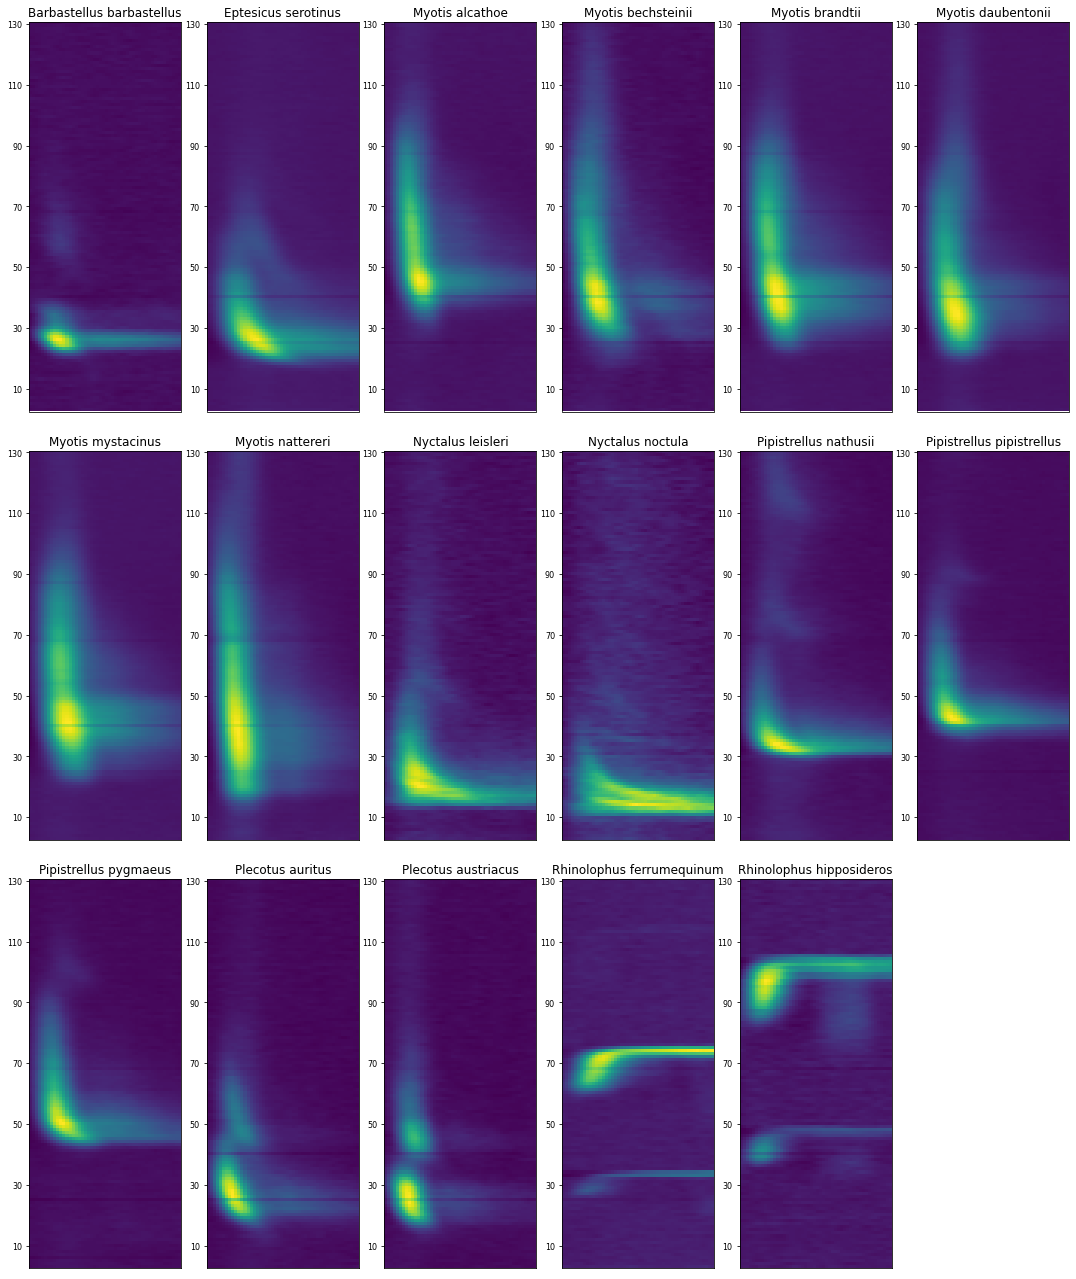

In [11]:
classes = ['Myotis daubentonii', 'Plecotus auritus', 'Pipistrellus pipistrellus',
 'Nyctalus leisleri' ,'Pipistrellus pygmaeus', 'Myotis mystacinus',
 'Myotis nattereri', 'Pipistrellus nathusii', 'Nyctalus noctula',
 'Eptesicus serotinus', 'Barbastellus barbastellus', 'Myotis brandtii',
 'Myotis alcathoe' ,'Myotis bechsteinii', 'Plecotus austriacus',
 'Rhinolophus ferrumequinum', 'Rhinolophus hipposideros']

classes.sort()

all_DF = df

avgs  = []
for className in classes:
    data = np.array(all_DF[all_DF['class'] == className].data.tolist())
    # test_data = np.array(test_DF[test_DF['class'] == className].data.tolist())
    
    
    if(data.size != 0):
        avg = np.average(data,axis=0)
        avgs.append(avg)
#         avg_fileName = 'train ' + className + '.pdf'
#         plot_spectrogram(np.flip(avg,0),avg_fileName)

count = 0
col = 3
row = 6
yticks = [0,10,30,50,70,90,110,130,140]
yticks.reverse()
fig, axes = plt.subplots(col, row)
fig.set_size_inches(15, 18)
for i in range(col):
    for j in range(row):
        
        if i == col - 1 and j == row - 1:
            axes[i, j].set_visible(False)
            continue
        
        a = avgs[count]
        a = cv2.resize(a, (50,128))
        axes[i,j].imshow(a)
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].set_yticklabels(yticks)
        axes[i,j].tick_params(labelsize=8)
        axes[i,j].set_title(classes[count], fontsize=12)
        count += 1
plt.tight_layout()
plt.savefig('avgImg.pdf', dpi=150)

In [ ]:
col = 3
row = 6
yticks = [0,10,30,50,70,90,110,130,140]
yticks.reverse()
fig, axes = plt.subplots(col, row)
fig.set_size_inches(15, 18)
for i in range(col):
    for j in range(row):
        a = cv2.resize(a, (40,128))
        axes[i,j].imshow(a)
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].set_yticklabels(yticks)
        axes[i,j].tick_params(labelsize=5)
        axes[i,j].set_title('jo')


        

[]

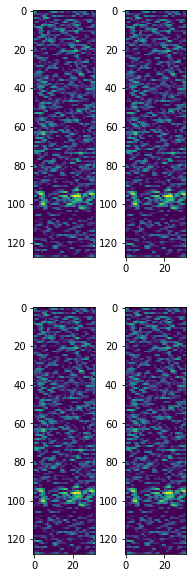

In [33]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(a)
axes[0, 1].imshow(a)
axes[1, 0].imshow(a)
axes[1, 1].imshow(a)
fig.set_size_inches(3, 10)
axes[0,0].get_xaxis().set_ticks([])

In [4]:
train_loader = genDataLoaderFromDataset('datasets/dataSet_1.pt', True, 1, 32)

torch.Size([334, 128, 32])
torch.Size([334])


In [5]:
# x = []

for i in train_loader:
    x = i
    break

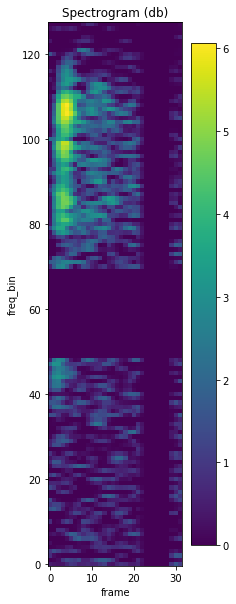

In [14]:
plot_spectrogram(x[0][10])

In [107]:
input1 = torch.randn(256, 128)
input2 = torch.randn(256, 128)
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(input1, input2)

In [227]:
def contrastAccEval(embeddings, indices):

    posiCount = 0

    for i in range(embeddings.size(dim=0)):
        if(i >= embeddings.size(dim=0)/2):
            break

        maxSim = 0
        maxIndex = -1

        for j in range(embeddings.size(dim=0)):
            if(i == j):
                continue
            
            cosSim = nn.CosineSimilarity(dim=0,eps=1e-15)
            currSim = cosSim(embeddings[i], embeddings[j])

            if(currSim > maxSim):
                maxSim = currSim
                maxIndex = j
        # print(indices[i])
        # print(indices[maxIndex])
        if (indices[i] == indices[maxIndex]):
            posiCount += 1
            # print(j)
            # print(i)
                            
    # print(posiCount)
    # print(embeddings.size(dim=0))
    # return 100 * (posiCount/(embeddings.size(dim=0)/2))
    return posiCount


In [238]:
def contrastAccEval(embeddings, indices):
    posiCount = 0
    exp = torch.from_numpy(pw.cosine_similarity(embeddings,embeddings))
    for i in range(embeddings.size(dim=0)):
        if(i >= embeddings.size(dim=0)/2):
            break

        maxIndex = torch.topk(exp[i], 2).indices[1]
        if (indices[i] == indices[maxIndex]):
            posiCount += 1
            # print(j)
            # print(i)
                            
    # print(posiCount)
    # print(embeddings.size(dim=0))
    # return 100 * (posiCount/(embeddings.size(dim=0)/2))
    
    return posiCount

In [241]:
torch.topk(indices, 3).indices

tensor([255, 254, 253])

In [242]:
indices = torch.arange(0, input1.size(0))
labels = torch.cat((indices,indices))
embeddings = torch.cat((input1,input2))

In [243]:
start_time = time.time()
b = (contrastAccEval(embeddings, labels))
print(time.time() - start_time)

0.03522324562072754


In [234]:
start_time = time.time()
a = (contrastAccEval(embeddings, labels))
print(time.time() - start_time)

0.03901243209838867


In [237]:
sums = 0
for i in range(len(b)):
    sums += a[i]-b[i]
    
sums

tensor(0)

In [112]:
output

tensor([ 0.0767, -0.0440, -0.0178,  0.0529, -0.0015,  0.0712,  0.1478,  0.0662,
         0.0391, -0.0860, -0.0617, -0.1132, -0.0121, -0.0957,  0.0527,  0.0201,
         0.0908, -0.0394, -0.0355,  0.0113,  0.1075, -0.0025, -0.1483, -0.0063,
        -0.0248, -0.0362, -0.0621,  0.0355, -0.0295, -0.0813,  0.0456,  0.0297,
        -0.1080,  0.0046,  0.0728,  0.0101, -0.0271,  0.0272, -0.0149,  0.0233,
        -0.0698, -0.0246, -0.0650,  0.0594, -0.0381,  0.0499,  0.0451, -0.0773,
        -0.0105,  0.0007, -0.0994,  0.0592,  0.0508,  0.0811,  0.0751, -0.0612,
        -0.0973, -0.0291,  0.0415,  0.0287,  0.0752,  0.0439, -0.0965,  0.0111,
         0.0903,  0.0461,  0.0031,  0.0558,  0.0878,  0.0122,  0.0746,  0.1527,
        -0.0007,  0.0431,  0.0966, -0.0120,  0.0354,  0.0293, -0.0317,  0.0552,
         0.0198, -0.0627, -0.0105, -0.0382, -0.0594,  0.0990, -0.0568, -0.0623,
         0.0197,  0.0384,  0.0162, -0.0680,  0.1202, -0.0140,  0.0571, -0.0348,
         0.0752, -0.0443,  0.0593,  0.06

In [113]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

output = cos(input1, input2)

In [114]:
output

tensor([-3.4061e-02, -1.0531e-01,  1.2016e-01,  8.9418e-02,  1.9810e-02,
        -5.3485e-02, -2.7344e-01,  1.2025e-03,  1.6350e-01,  9.0094e-02,
        -2.1196e-01, -7.1771e-02,  7.1962e-02, -3.2557e-02,  1.7580e-01,
         1.5433e-01, -1.0381e-01, -1.6534e-01, -4.8060e-02,  1.5757e-01,
        -5.6973e-02,  1.5360e-01, -3.3095e-02,  5.0594e-02,  6.1343e-03,
         1.3277e-01,  3.3554e-02, -2.9271e-03,  1.0475e-01,  6.9760e-03,
        -2.9661e-02,  7.2542e-02, -1.5151e-01, -2.3594e-02,  3.3792e-02,
        -3.4336e-02,  7.6901e-02,  1.7138e-01, -8.6530e-03, -7.4893e-02,
        -5.6965e-02, -1.1872e-01,  9.7109e-02,  4.7889e-02, -1.8779e-02,
         1.2390e-01, -6.9650e-02,  3.5544e-02, -1.3346e-02, -6.9259e-02,
        -8.4932e-02,  1.5843e-03,  2.8318e-02,  1.6829e-02,  1.1958e-01,
        -7.4736e-02, -3.3036e-02, -4.7730e-02,  4.4065e-02, -9.6746e-02,
         1.6625e-02, -6.2920e-02,  7.8572e-02, -7.1877e-04,  3.8457e-03,
        -3.0286e-02, -3.4830e-02,  6.4051e-02,  2.8

In [176]:
pw.cosine_similarity(input1,input2)[9][9]

0.09009444

In [177]:
cosSim = nn.CosineSimilarity(dim=1,eps=1e-15)
currSim = cosSim(input1,input2)
currSim[9]

tensor(0.0901)

In [116]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(input1[0], input2[0])
output

tensor(-0.0341)

In [16]:
x[0].size()

torch.Size([32, 128, 32])

In [4]:
x[0].shape
num = random.randint(0,31)
plot_spectrogram(x[0][num])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-ddd48d64f88a>", line 3, in <module>
    plot_spectrogram(x[0][num])
NameError: name 'plot_spectrogram' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/lib/python3/dist-packages/IPython/core/ultratb.py", line 316, in wra

NameError: name 'plot_spectrogram' is not defined

In [38]:
train_dataset = getDataLoader(20,False,True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-a7b3cb2d4211>", line 1, in <module>
    train_dataset = getDataLoader(20,False,True)
  File "/home/s1918275/AndyDissertation/src/dfLoader.py", line 265, in getDataLoader
    df = dfLoader(annPath, audioPath, allData = True)
  File "/home/s1918275/AndyDissertation/src/dfLoader.py", line 131, in dfLoader
    data = json.load(open(ann_path))
FileNotFoundError: [Errno 2] No such file or directory: 'annotations/bcireland_expert.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above 

FileNotFoundError: [Errno 2] No such file or directory: 'annotations/bcireland_expert.json'

In [85]:
load_train_dataset.tensors[1].repeat(3).shape

torch.Size([501])

In [26]:
torch.save(train_dataset, 'datasets/dataSet.pt')

In [77]:
load_train_dataset = torch.load('datasets/dataSet_1.pt')

In [67]:
next(iter(load_train_dataset))

(tensor([[ 3.5591,  3.3493,  4.6335,  ...,  4.6129,  4.8209,  4.2699],
         [ 7.9563,  6.7806,  6.4020,  ...,  7.3254,  8.0196,  7.7990],
         [11.4533, 10.4696, 12.0586,  ..., 10.9669, 10.8736, 10.2907],
         ...,
         [17.0450, 18.9396, 19.5347,  ..., 18.5930, 18.2747, 17.3089],
         [17.9427, 17.8345, 17.6060,  ..., 18.9641, 17.4456, 18.3704],
         [18.9150, 18.2247, 17.6661,  ..., 17.9330, 18.0387, 17.6551]]),
 tensor(0.))

In [61]:
len(load_train_dataset)

173

In [15]:
dataLoader = DataLoader(load_train_dataset, batch_size = 20, shuffle=True)


In [20]:
for i in dataLoader:
    print(i[0].shape)

torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([

torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([20, 128, 32])
torch.Size([